# Báo cáo đồ án cuối kì môn Lập trình song song
## Autoencoder-based unsupervised feature learning system
---------------

## Nhóm 2
- Lê Minh Quân
- Liêu Hải Lưu Danh
- Phan Nguyễn Minh Khôi

### I. Chuẩn bị môi trường

In [1]:
!git clone https://github.com/lhldanh/Autoencoder-based-unsupervised-feature-learning-system.git
%cd Autoencoder-based-unsupervised-feature-learning-system/

Cloning into 'Autoencoder-based-unsupervised-feature-learning-system'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 240 (delta 5), reused 10 (delta 2), pack-reused 225 (from 1)
Receiving objects: 100% (240/240), 162.55 KiB | 5.24 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/Autoencoder-based-unsupervised-feature-learning-system


In [2]:
%mkdir -p build
%mkdir -p weights
%mkdir -p data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz -O data/cifar-10-binary.tar.gz
!tar -xzvf data/cifar-10-binary.tar.gz -C data

--2025-12-14 16:58:41--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘data/cifar-10-binary.tar.gz’

data/cifar-10-binar 100%[===================>] 162.17M  53.6MB/s    in 3.0s    

2025-12-14 16:58:44 (53.6 MB/s) - ‘data/cifar-10-binary.tar.gz’ saved [170052171/170052171]

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin


### **II. Báo cáo chính**
#### **1. Mô tả đồ án**
##### **1.1. Mô tả vấn đề**
- Xây dựng một mô hình **Convolutional Autoencoder** (CAE) sử dụng bộ dữ liệu CIFAR-10 để **học cách biểu dữ đặc trưng (feature extraction)**, sau đó thông qua nó dùng mô hình Support Vector Machine để thực hiện bài toán phân loại hình ảnh.


- Việc huấn luyện các mạng CNN **đòi hỏi khối lượng tính toán lớn**, đặc biệt là các phép nhân ma trận và tích chập.
    - **Hạn chế của CPU:** Xử lý tuần tự hoặc song song hạn chế, không đáp ứng được yêu cầu về thời gian huấn luyện thực tế cho dữ liệu lớn.

    - **Lợi thế của GPU:** Với kiến trúc gồm hàng nghìn lõi cuda cores, GPU cho phép thực hiện đồng thời rất rất nhiều phép tính dấu phẩy động.
    - **Mục tiêu tối ưu:** Đồ án này yêu cầu tự cài đặt các thuật toán bằng CUDA C++ để tối ưu hóa lập trình song song trên GPU

#### **1.2. Mô tả bộ dữ liệu**
##### **1.2.1. Thông số kỹ thuật**
- **Tên:** CIFAR-10 (Canadian Institute For Advanced Research).

- **Kích thước:** 60,000 ảnh màu (RGB).

- **Độ phân giải:** 32x32 pixels.

- **Số lượng lớp:** 10 lớp đối tượng (Máy bay, Ô tô, Chim, Mèo, Hươu, Chó, Ếch, Ngựa, Tàu thủy, Xe tải).

- **Phân chia dữ liệu:**

  - **Tập huấn luyện:** 50,000 ảnh.

  - **Tập kiểm tra:** 10,000 ảnh.
##### **1.2.2. Minh hoạ bộ dữ liệu**

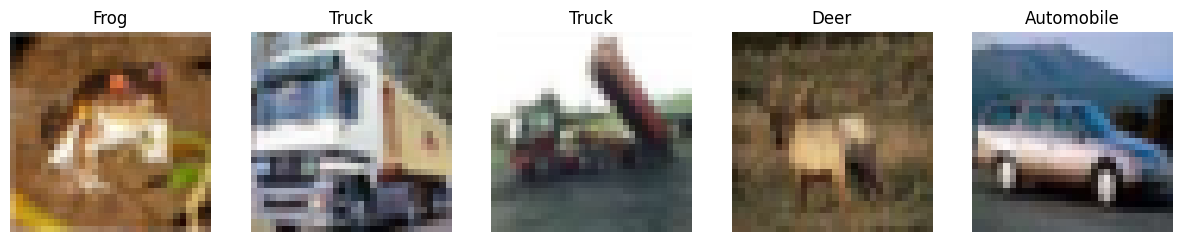

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

file_path = 'data/cifar-10-batches-bin/data_batch_1.bin'

def show_cifar_images():
    # Kiểm tra file có tồn tại không
    if not os.path.exists(file_path):
        print(f"Lỗi: Không tìm thấy file tại {file_path}")
        print("Hãy đảm bảo lệnh '!tar -xzvf ...' đã chạy thành công.")
        return

    with open(file_path, 'rb') as f:
        content = f.read()
    data = np.frombuffer(content, dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images_flat = data[:, 1:]

    images = images_flat.reshape(-1, 3, 32, 32)

    images = images.transpose(0, 2, 3, 1)

    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.show()

show_cifar_images()

##### **1.2.3. Tiền xử lý dữ liệu**
- Chuyển kiểu dữ liệu từ uint8 → float
- Áp dụng min-max normalization

#### **1.3. Kiến trúc mạng của Autoencoder**
##### **1.3.1. Diagram:** nhóm dùng đúng theo kiến trúc đề bài yêu cầu

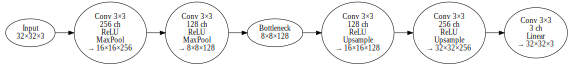

In [10]:
from graphviz import Digraph

dot = Digraph(format="png")
dot.attr(rankdir="LR", size="8,5")

# Input
dot.node("Input", "Input\n32×32×3")

# Encoder
dot.node("Conv1", "Conv 3×3\n256 ch\nReLU\nMaxPool\n→ 16×16×256")
dot.node("Conv2", "Conv 3×3\n128 ch\nReLU\nMaxPool\n→ 8×8×128")

# Bottleneck
dot.node("Bottle", "Bottleneck\n8×8×128")

# Decoder
dot.node("Conv3", "Conv 3×3\n128 ch\nReLU\nUpsample\n→ 16×16×128")
dot.node("Conv4", "Conv 3×3\n256 ch\nReLU\nUpsample\n→ 32×32×256")

# Output
dot.node("Out", "Conv 3×3\n3 ch\nLinear\n→ 32×32×3")

# Edges
dot.edges([
    ("Input", "Conv1"),
    ("Conv1", "Conv2"),
    ("Conv2", "Bottle"),
    ("Bottle", "Conv3"),
    ("Conv3", "Conv4"),
    ("Conv4", "Out")
])

dot

#### **1.4. Mục tiêu đồ án**
##### **1.4.1. Hiệu năng**
- Tăng tốc độ (Speedup): Đạt tốc độ huấn luyện nhanh hơn so với cài đặt C++ thuần chạy trên CPU.

- Độ chính xác: Giảm thiểu loss của Autoencoder xuống mức thấp nhất có thể, và độ chính xác ổn định khi phân loại ảnh với SVM
##### **1.4.2. Kỹ thuật**
*Nắm rõ một số kĩ thuật Advanced Optimization khi lập trình song song với GPU như:*
- **Shared Memory Tiling:** Sử dụng bộ nhớ chia sẻ (__shared__) để giảm độ trễ truy cập bộ nhớ toàn cục (Global Memory) trong các phép nhân ma trận (GEMM).
- **Convert to Matrix Multiplication**: Chuyển đổi bài toán tích chập (Convolution) thành phép nhân ma trận (Matrix Multiplication) để tận dụng sức mạnh của các kernel GEMM tối ưu.
- **Register Blocking (Thread Coarsening):** Tối ưu hóa sâu hơn bằng cách sử dụng thanh ghi (float acc[THREAD_M][THREAD_N]) để lưu trữ kết quả trung gian, giảm áp lực lên Shared Memory và tăng thông lượng tính toán.
- **Parallel Reduction:** Thực hiện kỹ thuật khử (reduction) trên cây nhị phân trong Shared Memory để tính hàm mất mát (MSE Loss) hiệu quả.
- **Kernel Fusion:** Gộp các thao tác tính toán liên tiếp như GEMM + Bias Add + ReLU vào một kernel duy nhất để giảm băng thông bộ nhớ và chi phí khởi chạy kernel
- **Vectorized Memory Access:** Sử dụng kiểu dữ liệu float4 để đọc/ghi 128-bit dữ liệu trong một lệnh, tối đa hóa băng thông bộ nhớ trong các tác vụ SGD và khởi tạo.
- **Pinned (Page-Locked) Memory:** Sử dụng CUDA Streams và Pinned Memory (cudaMallocHost) để thực hiện song song việc nạp dữ liệu (H2D) và tính toán (Compute), che giấu độ trễ truyền tải dữ liệu.
##### **1.4.3. Tiêu chí thành công**
- Chương trình biên dịch và chạy không có lỗi.
- Loss giảm đều đặn qua các epoch.
- Chứng minh được hiệu quả của việc tối ưu hóa.
- Phân loại hình ảnh với SVM đạt hiệu quả tốt (accuracy > 60%)

### **2. Kết quả cài đặt**
#### **2.1. Trên CPU**

In [7]:
!g++ -std=c++17 -O3 src/train_cpu.cpp src/cifar10_dataset.cpp src/kernels_cpu.cpp -I include -o build/cpu_train
!./build/cpu_train

--- Loading CIFAR-10 Dataset ---
Loaded batch: data/cifar-10-batches-bin/data_batch_1.bin | Current Total: 10000
Loaded batch: data/cifar-10-batches-bin/data_batch_2.bin | Current Total: 20000
Loaded batch: data/cifar-10-batches-bin/data_batch_3.bin | Current Total: 30000
Loaded batch: data/cifar-10-batches-bin/data_batch_4.bin | Current Total: 40000
Loaded batch: data/cifar-10-batches-bin/data_batch_5.bin | Current Total: 50000
Loaded batch: data/cifar-10-batches-bin/test_batch.bin | Current Total: 10000
Successfully loaded 50000 train images and 10000 test images.
--- START TRAINING (CPU) ---
Config: 5 Epochs, ~96 Images
Batch Size: 32, Learning Rate: 0.001

Epoch 0 Done. Avg Loss: 0.278847 | Time: 111.486s
Epoch 1 Done. Avg Loss: 0.274819 | Time: 110.424s
Epoch 2 Done. Avg Loss: 0.270923 | Time: 109.595s
Epoch 3 Done. Avg Loss: 0.267148 | Time: 111.689s
Epoch 4 Done. Avg Loss: 0.26348 | Time: 109.95s

Total Training Time: 553.144 seconds
--- SAVING FULL MODEL ---


Thời gian training của CPU đối với setting (max_image = 96, batch_size = 32, lr = 0.001, epochs = 5) là:
- Khoảng 110 giây cho 1 epochs
- Tổng thời gian là 553.144 giây

#### **2.1. Trên GPU**
##### **2.1.1. Naive GPU**

In [9]:
!nvcc -arch=sm_75 -o build/train_gpu src/train_gpu.cu src/cifar10_dataset.cpp -I include/
!./build/train_gpu

--- Loading CIFAR-10 Dataset ---
Loaded batch: data/cifar-10-batches-bin/data_batch_1.bin | Current Total: 10000
Loaded batch: data/cifar-10-batches-bin/data_batch_2.bin | Current Total: 20000
Loaded batch: data/cifar-10-batches-bin/data_batch_3.bin | Current Total: 30000
Loaded batch: data/cifar-10-batches-bin/data_batch_4.bin | Current Total: 40000
Loaded batch: data/cifar-10-batches-bin/data_batch_5.bin | Current Total: 50000
Loaded batch: data/cifar-10-batches-bin/test_batch.bin | Current Total: 10000
Successfully loaded 50000 train images and 10000 test images.
--- START TRAINING (CUDA) ---
Batch Size: 32, Epochs: 5, Learning Rate: 0.001
Max Images: 96

Epoch 1 Done. Avg Loss: 0.24119 | Time: 0.999621s

Epoch 2 Done. Avg Loss: 0.23562 | Time: 1.98062s

Epoch 3 Done. Avg Loss: 0.23022 | Time: 2.96244s

Epoch 4 Done. Avg Loss: 0.224972 | Time: 3.94791s

Epoch 5 Done. Avg Loss: 0.219859 | Time: 4.93234s

--- Training Complete ---
Total Training Time: 4.93239 seconds

--- Cleaning up 

Thời gian training của Naive GPU đối với setting (max_image = 96, batch_size = 32, lr = 0.001, epochs = 5) là:
- Khoảng 0.98 giây cho 1 epochs
- Tổng thời gian là 4.932 giây

##### **2.1.1. Advanced Optimization**

In [14]:
!nvcc -arch=sm_75 -o build/train_gpu_optimize src/train_gpu_optimize.cu src/cifar10_dataset.cpp -I include/
!./build/train_gpu_optimize

=== CUDA Autoencoder (Fused Backward Kernels) ===

GPU: Tesla T4
SMs: 40

--- Loading CIFAR-10 Dataset ---
Loaded batch: data/cifar-10-batches-bin/data_batch_1.bin | Current Total: 10000
Loaded batch: data/cifar-10-batches-bin/data_batch_2.bin | Current Total: 20000
Loaded batch: data/cifar-10-batches-bin/data_batch_3.bin | Current Total: 30000
Loaded batch: data/cifar-10-batches-bin/data_batch_4.bin | Current Total: 40000
Loaded batch: data/cifar-10-batches-bin/data_batch_5.bin | Current Total: 50000
Loaded batch: data/cifar-10-batches-bin/test_batch.bin | Current Total: 10000
Successfully loaded 50000 train images and 10000 test images.
Images loaded: 50000
Training on: 96 images
Batch Size: 32
Batches per epoch: 3

Memory: 892 MB

Training: 5 epochs, 3 batches

Epoch 1/5 | Loss: 0.210273 | Time: 0.37s | 262 img/s
Epoch 2/5 | Loss: 0.208622 | Time: 0.21s | 467 img/s
Epoch 3/5 | Loss: 0.205030 | Time: 0.20s | 471 img/s
Epoch 4/5 | Loss: 0.201522 | Time: 0.20s | 471 img/s
Epoch 5/5 | L

Thời gian training của GPU khi sử dụng các kĩ thuật Advanced Optimization đối với setting (max_image = 96, batch_size = 32, lr = 0.001, epochs = 5) là:

Khoảng 0.2 giây cho 1 epochs
Tổng thời gian là 1 giây

**Bảng tổng kết thời gian chạy**
| Phase | Training Time (s) | Speedup (vs CPU) |
|------|-------------------|------------------|
| CPU Baseline | 553.144 | 1.0× |
| Naive GPU | 4.932 | 112.2× |
| Optimized GPU  | 1.0 | 553.1× |


#### **3. Phân tích kĩ thuật Advanced Optimization đã dùng**

#### **4. Kết quả mô hình phân loại hình ảnh SVM**